In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os

In [39]:
# 迁移学习： 从ImageNet中已经训练好的神经网络 迁移并适配
data_dir = '06_transfer_ant_bee_data'
image_size = 224

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                     transforms.Compose([
                                         transforms.RandomResizedCrop(image_size), #  裁剪到指定大小
                                         transforms.RandomHorizontalFlip(), # 默认0.5的概率随机水平翻转
                                         transforms.ToTensor(), # RBG三个通道数据 归一化到[0, 1](除以255)
                                         
                                         # 简单来说就是将数据按通道进行计算，将每一个通道的数据先计算出其方差与均值，
                                         # 然后再将其每一个通道内的每一个数据减去均值，再除以方差，x = (x - mean) / std，得到归一化后的结果。
                                         # 在深度学习图像处理中，标准化处理之后，可以使数据更好的响应激活函数，提高数据的表现力，
                                         # 减少梯度爆炸和梯度消失的出现。
                                         
                                         # ImageNet数据集的均值和方差为：mean=(0.485, 0.456, 0.406)，std=(0.229, 0.224, 0.225)，
                                         # 因为这是在百万张图像上计算而得的，所以我们通常见到在训练过程中使用它们做标准化。
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 归一化结果不一定是[-1，1]
                                     ])
                                    )
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                   transforms.Compose([
                                       transforms.Resize(256),  # 图像放大到 256 * 256
                                       transforms.CenterCrop(image_size), # 从中心区域切割 224 * 224
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                   ])
                                  )


# 创建数据加载器
# num_workers 指定工作进程的个数，负责加载batch，一般设置为cpu核心数或一半
# batch_size: 每批的数据大小
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, shuffle = True, num_workers = 4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 4, shuffle = True, num_workers = 4)

# dataset.classes: 读取数据集下文件夹名并将其作为类别存入列表，如 train目录下有 ants和 bees两个文件夹，所以类别数为2
num_classes = len(train_dataset.classes) 

# 计算分类准确度
def rightness(predictions, labels):
    # max函数返回[value, index], pred得到最大概率的索引，0表示好，1表示负面
    pred = torch.max(predictions.data, 1)[1] # max的dim=1 表示沿着第二个维度计算max，即好或坏两个分类数值， 

    rights = pred.eq(labels.data.view_as(pred)).sum()

    return rights, len(labels)

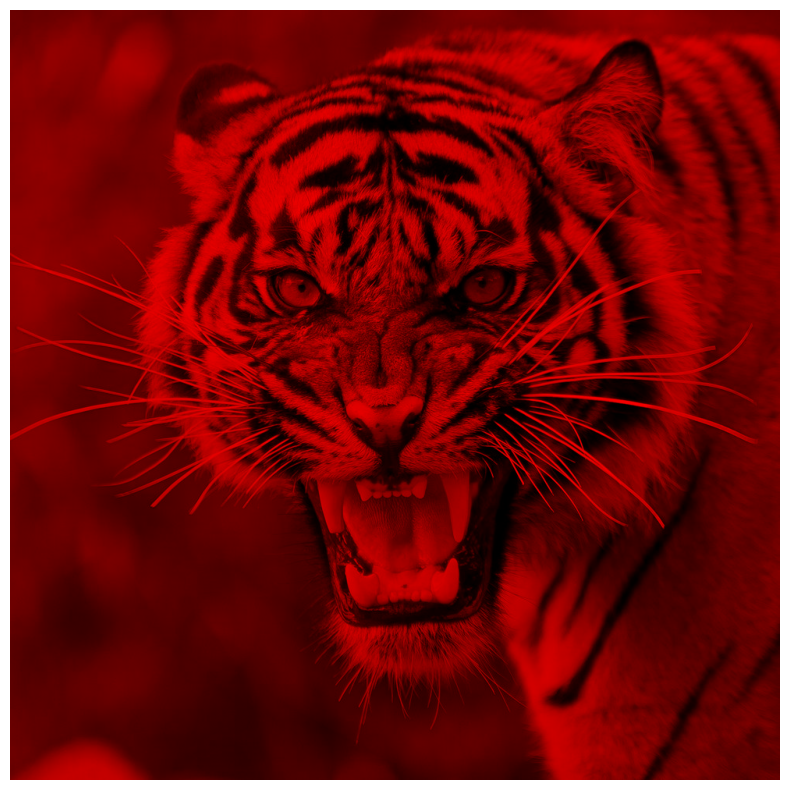

In [63]:
img_array = plt.imread('06_transfer_ant_bee_data/tiger.jpeg') # [rows, cols, channels]: 987, 987, 3
tiger = img_array/255 # 归一化

red_tiger = tiger.copy()
red_tiger[:, :, [1,2]] = 0 # r, g, b 中只保留颜色r
 
plt.figure(figsize=(10, 10))
plt.imshow(red_tiger)
plt.axis('off')
plt.show()

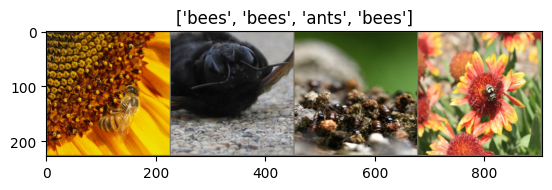

In [74]:
def imshow(inp, title=None):
    # 将一张图打印显示出来，inp为一个张量，title为显示在图像上的文字
    
    #一般的张量格式为：channels*image_width*image_height
    #而一般的图像为image_width*image_height*channels所以，需要将channels转换到最后一个维度
    inp = inp.numpy().transpose((1, 2, 0)) 
    
    #由于在读入图像的时候所有图像的色彩都标准化了，因此我们需要先调回去
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    #将图像绘制出来
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 暂停一会是为了能够将图像显示出来。


#获取第一个图像batch和标签
images, labels = next(iter(train_loader))

# 将这个batch中的图像制成表格绘制出来
out = torchvision.utils.make_grid(images)  # 4个图像拼接起来维度为： [3, 228, 906]， 也就是 [channels, height, 4 * width]

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [ ]:
# torchvision的models模块 封装了 大量已训练好的 网络模型和模型操作方法 供开发者调用
net = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)

# 预训练模式， 改变原网络模型的权重
num_ftrs = net.fc.in_features # fc: full connnection全连接层， num_ftrs存储了ResNet18最后的全连接层的输入神经元个数
net.fc = nn.Linear(num_ftrs, 2) # 替换全连接层，替换为输出单元为2的全连接层

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

print(net) # 打印网络架构

In [ ]:
# torchvision的models模块 封装了 大量已训练好的 网络模型和模型操作方法 供开发者调用
net = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)

# 固定值的模式， 不改变原网络模型的权重
for param in net.parameters():
    param.requires_grad = False # 不需要计算梯度
num_ftrs = net.fc.in_features # fc: full connnection全连接层， num_ftrs存储了ResNet18最后的全连接层的输入神经元个数
net.fc = nn.Linear(num_ftrs, 2) # 替换全连接层，替换为输出单元为2的全连接层

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.fc.parameters(), lr=0.0001, momentum=0.9)

print(net) # 打印网络架构

In [80]:
# 开始训练，不用区分是否是 预训练模式 或 固定模式
record = []
num_epochs = 20

net.train(True)
best_model = net
best_r = 0.0

for epoch in range(num_epochs):
    train_rights = []
    train_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        output = net(data)
        loss = criterion(output, target)
        optimizer.zero_grad() # 清空梯度
        loss.backward() # 反向传播
        optimizer.step() # 随机梯度下降

        right = rightness(output, target)
        train_rights.append(right)
        train_losses.append(loss.data.numpy())
    
    train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
    
    #在测试集上分批运行，并计算总的正确率
    net.eval() #标志模型当前为运行阶段
    val_rights = []
    #对测试数据集进行循环
    for data, target in val_loader:
        # 如果不适用clone方法， detach后的张量与原张量共享同一存储空间， 修改会彼此影响。
        data, target = data.clone().detach().requires_grad_(False), target.clone().detach()
        
        output = net(data) #将特征数据喂入网络，得到分类的输出
        val = rightness(output, target) #获得正确样本数以及总样本数
        val_rights.append(val) #记录结果

    #计算准确率
    val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
    val_ratio = 1.0*val_r[0]/val_r[1]
    
    if val_ratio > best_r:
        best_r = val_ratio
        best_model = copy.deepcopy(net)
    #打印准确率等数值，其中正确率为本训练周期Epoch开始后到目前撮的正确率的平均值
    print('训练周期: {} \tLoss: {:.6f}\t训练正确率: {:.2f}%, 校验正确率: {:.2f}%'.format(
        epoch, np.mean(train_losses), 100. * train_r[0].numpy() / train_r[1], 100. * val_r[0].numpy()/val_r[1]))       
    record.append([np.mean(train_losses), train_r[0].numpy() / train_r[1], val_r[0].numpy()/val_r[1]])

        

训练周期: 0 	Loss: 0.499723	训练正确率: 76.02%, 校验正确率: 90.85%
训练周期: 1 	Loss: 0.274924	训练正确率: 90.24%, 校验正确率: 94.77%
训练周期: 2 	Loss: 0.193734	训练正确率: 92.68%, 校验正确率: 90.85%
训练周期: 3 	Loss: 0.157953	训练正确率: 94.31%, 校验正确率: 90.20%
训练周期: 4 	Loss: 0.104749	训练正确率: 96.34%, 校验正确率: 92.16%
训练周期: 5 	Loss: 0.139321	训练正确率: 93.50%, 校验正确率: 93.46%
训练周期: 6 	Loss: 0.078060	训练正确率: 97.56%, 校验正确率: 91.50%
训练周期: 7 	Loss: 0.168181	训练正确率: 94.31%, 校验正确率: 91.50%
训练周期: 8 	Loss: 0.090180	训练正确率: 97.15%, 校验正确率: 94.12%
训练周期: 9 	Loss: 0.138203	训练正确率: 93.90%, 校验正确率: 92.81%
训练周期: 10 	Loss: 0.085198	训练正确率: 96.75%, 校验正确率: 94.12%
训练周期: 11 	Loss: 0.073053	训练正确率: 97.15%, 校验正确率: 94.12%
训练周期: 12 	Loss: 0.102618	训练正确率: 96.34%, 校验正确率: 92.16%
训练周期: 13 	Loss: 0.106427	训练正确率: 95.93%, 校验正确率: 93.46%
训练周期: 14 	Loss: 0.096413	训练正确率: 96.34%, 校验正确率: 90.85%
训练周期: 15 	Loss: 0.061052	训练正确率: 98.78%, 校验正确率: 92.81%
训练周期: 16 	Loss: 0.073085	训练正确率: 96.34%, 校验正确率: 93.46%
训练周期: 17 	Loss: 0.128386	训练正确率: 94.31%, 校验正确率: 93.46%
训练周期: 18 	Loss: 0.052776	训练正确率: 97.97%

In [83]:
#在测试集上分批运行，并计算总的正确率
net.eval() #标志模型当前为运行阶段

vals = []

#对测试数据集进行循环
for data, target in val_loader:
    data, target = data.clone().detach().requires_grad_(False), target.clone().detach()
    
    output = net(data) #将特征数据喂入网络，得到分类的输出
    val = rightness(output, target) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].numpy() / rights[1]
right_rate

0.9215686274509803

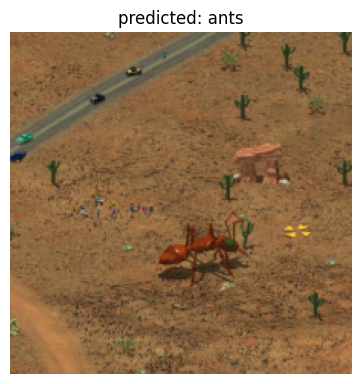

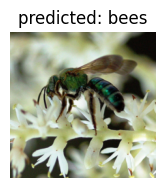

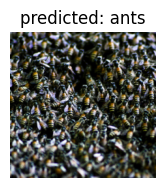

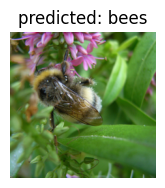

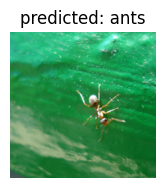

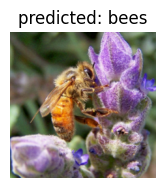

In [93]:
# 将预训练的模型用于测试数据，打印其分类效果
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure(figsize=(15,10))

    for i, data in enumerate(val_loader):
        inputs, labels = data

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1) # 返回最大概率值的索引
        preds = preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            
            ax.set_title('predicted: {}'.format(val_dataset.classes[preds[j]]))
            imshow(data[0][j])

            if images_so_far == num_images:
                return
                
visualize_model(net)

plt.ioff() # 关闭交互模式
plt.show()